In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [39]:
import seaborn as sns
from sklearn import feature_extraction, linear_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow import keras
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


# Disaster Tweet Detection

This project is part of a kaggle competition to detect tweets about disaster events using NLP techniques. More information about the competition can be found here: https://www.kaggle.com/c/nlp-getting-started/overview

Both test and training data for this project are provided as csv files. The training data includes 7613 rows containing, an id, keywords, location, the text of the tweet, and a target of either 0 for a non-disaster tweet, or a 1 for a tweet determined to be about a disaster.

The training data contains 3263 rows, which follow the same format, but missing the disaster labels.

## EDA

We will first load in our data and do a bit of exploration.

In [40]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [42]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [43]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [44]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Before we dive into classifying tweets as 'Disaster' or 'Non-disaster' related, we can quickly take a look at a few examples of what tweets from each classification looks like. In this case, "Disaster Tweets" have been labeled with 1, while non-disaster tweets are labeled with 0 - we can take a quick look at the first few tweets from each label to see the difference.

In [45]:
train_df[train_df["target"] == 0]["text"].values[0:4]

array(["What's up man?", 'I love fruits', 'Summer is lovely',
       'My car is so fast'], dtype=object)

In [46]:
train_df[train_df["target"] == 1]["text"].values[0:4]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California '],
      dtype=object)

We can also quickly visualize how many tweets are disaster vs non disaster with a quick chart.

<Axes: xlabel='target', ylabel='count'>

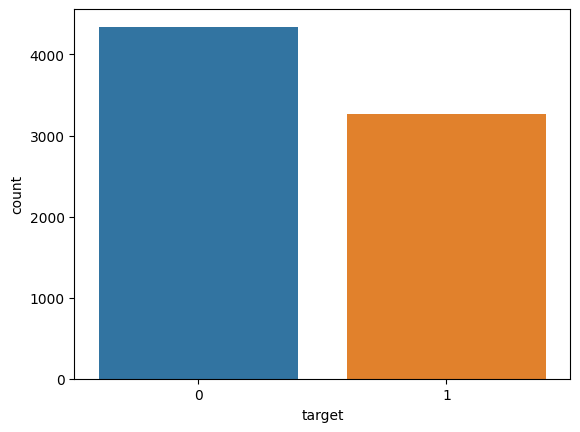

In [47]:
sns.countplot(data = train_df, x = train_df['target'])

Along with the tweets themselves, we also have data about keywords and locations, we can quickyly explore these as well.

In [48]:
train_df['keyword'].value_counts()[:20]

keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64

The keywords seem to make sense as words that would be highly correlated with a dangerous or disaster type situation. Of note, there appears that there may be some values with some odd characters, such as 'body%20bags', as well as some with significant overlap - such as 'weapon' and 'weapons'.

In [49]:
train_df["location"].value_counts()[:20]

location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: count, dtype: int64

The location data does not appear to be well structured. There are seperate values for the same country, such as 'USA' and 'United States'. Additionally, some locations are recorded at a country level, while others are recorded at a City or a state level. There also appears to be some potentially ambiguous locations such as 'Worldwide' or 'Everywhere'.

# First Attempt - Ridge Classifier

To get started, we will try something fairly simple. Kaggle's getting started notebook (https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook) that is associated with this challenge used a ridge classifier, so we will try something similar to start.

In [50]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'],test_size=0.2, random_state= 123 )

In [51]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(X_train)

val_vectors = count_vectorizer.transform(X_val)

test_vectors = count_vectorizer.transform(test_df['text'])

In [52]:
clf = linear_model.RidgeClassifier(solver = 'lsqr')

clf.fit(train_vectors, y_train)

RidgeClassifier(solver='lsqr')

In [53]:
clf.score(train_vectors, y_train)

0.9958949096880131

In [54]:
clf.score(val_vectors, y_val)

0.7866053841103086

In [55]:
preds = clf.predict(test_vectors)

preds[:10]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0])

In [56]:
sub1 = test_df

sub1['target'] = preds

sub1 = sub1[['id', 'target']]

sub1.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [57]:
sub1_csv = sub1.to_csv('submission1.csv', index = False)

The ridge classifier did okay -  it scored 0.78 on the validation set. I submitted it to the compitition, and it similarly scored 0.778 on the test set. This is a decent starting point, and gives us a baseline to improve from. Now we cant try some more complex things to see how we can improve.

## Additional Preprocessing

One area that might help us improve upon our basic approach is to do some more pre-processing of the text.

In [58]:
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords

In [59]:
#STOPWORDS.difference()

stop_words = STOPWORDS

In [60]:
def clean_tweets(text):
    
    text = re.sub('@[^\s]+','', text) #remove user @'s'
    text = text.lower()
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , text)#remove hyperlinks
    text = re.sub(r'\brt\b', "", text).strip() #remove retweets
    text = re.sub(r'[^\w]+', " ", text)
    text = remove_stopwords(text)
    #text = text.split()
    
    
    return text

In [61]:
X_train_clean = X_train.apply(clean_tweets)

In [62]:
X_train_clean.head()

6445    turkish troops killed kurdish militant suicide...
3870    gray ophelia red flames blazing person setting...
2431    tubestrike derailed robertwelch cutlery offers...
5355    truly scene chaos unprecedented frenzy pandemo...
6496    sunk fact actually moving state colorado tomor...
Name: text, dtype: object

In [63]:
X_val_clean = X_val.apply(clean_tweets)

In [64]:
X_val_clean.head()

1971    1970 mercury cyclone gt hood moulding nice cor...
2502                                desolate hope 2 mirad
5371                     laughing talking junk panic mode
6258                                        finally storm
549        dragon ball z battle gods 2014 rotten tomatoes
Name: text, dtype: object

In [65]:
test_clean = test_df['text'].apply(clean_tweets)

In [66]:
vocab_size = 10000
embedding_dim = 16
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [67]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_clean)

In [68]:
training_sequences = tokenizer.texts_to_sequences(X_train_clean)
val_sequences = tokenizer.texts_to_sequences(X_val_clean)
test_sequences = tokenizer.texts_to_sequences(test_clean)

In [69]:
training_sequences = pad_sequences(training_sequences, maxlen = max_length, truncating = trunc_type,padding = padding_type)
val_sequences = pad_sequences(val_sequences, maxlen = max_length, truncating = trunc_type,padding = padding_type)
test_sequences = pad_sequences(test_sequences, maxlen = max_length, truncating = trunc_type,padding = padding_type)

In [70]:
training_sequences = np.array(training_sequences)
val_sequences = np.array(val_sequences)
test_sequences = np.array(test_sequences)

y_train = np.array(y_train)
y_val = np.array(y_val)

## Neural Network Model

Now that we have done some additional pre-processing of our tweet data, we will experiment with some neural network models to see if we can improve from our first attempt with the ridge classifier.

In [71]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [72]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True
)

In [73]:
history = model.fit(training_sequences, y_train, epochs=50, validation_data=(val_sequences, y_val), callbacks = early_stopping, verbose=2)

Epoch 1/50
191/191 - 2s - 11ms/step - accuracy: 0.5686 - loss: 0.6848 - val_accuracy: 0.5772 - val_loss: 0.6808
Epoch 2/50
191/191 - 1s - 3ms/step - accuracy: 0.5686 - loss: 0.6832 - val_accuracy: 0.5772 - val_loss: 0.6842
Epoch 3/50
191/191 - 1s - 3ms/step - accuracy: 0.5686 - loss: 0.6835 - val_accuracy: 0.5772 - val_loss: 0.6799
Epoch 4/50
191/191 - 1s - 3ms/step - accuracy: 0.5686 - loss: 0.6826 - val_accuracy: 0.5772 - val_loss: 0.6793
Epoch 5/50
191/191 - 1s - 3ms/step - accuracy: 0.5686 - loss: 0.6835 - val_accuracy: 0.5772 - val_loss: 0.6859
Epoch 6/50
191/191 - 1s - 3ms/step - accuracy: 0.5721 - loss: 0.6815 - val_accuracy: 0.5772 - val_loss: 0.6782
Epoch 7/50
191/191 - 1s - 3ms/step - accuracy: 0.5703 - loss: 0.6805 - val_accuracy: 0.5772 - val_loss: 0.6766
Epoch 8/50
191/191 - 1s - 3ms/step - accuracy: 0.5721 - loss: 0.6805 - val_accuracy: 0.5772 - val_loss: 0.6744
Epoch 9/50
191/191 - 1s - 3ms/step - accuracy: 0.5752 - loss: 0.6761 - val_accuracy: 0.5772 - val_loss: 0.6720


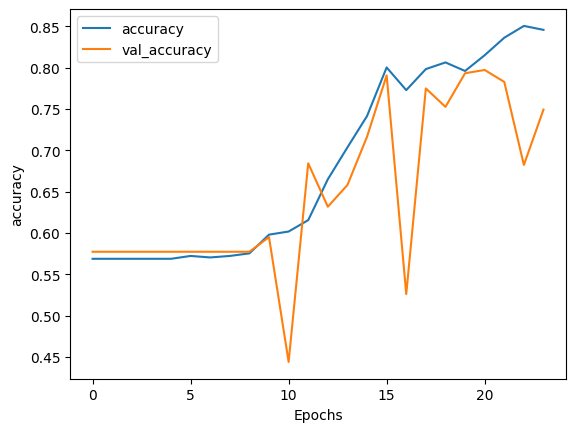

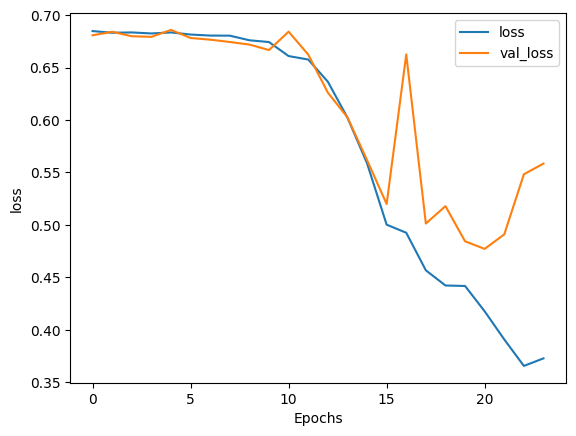

In [74]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [75]:
test_preds = model.predict(test_sequences)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [76]:
test_preds[:5]

array([[0.72909546],
       [0.67551225],
       [0.68888706],
       [0.50566226],
       [0.90567714]], dtype=float32)

In [77]:
test_preds = np.where(test_preds >=0.5, 1, 0)

test_preds[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [78]:
sub2 = sub1.copy()
sub2['target'] = test_preds

In [79]:
sub2_csv = sub2.to_csv('submission2.csv', index = False)

This second submission scored a .80049, which is a notable improvement from our original submission. This is pretty decent, but I am curious to try a couple other simple models, so we will also make a quick LSTM model and a simple RNN model.

## LSTM

In [80]:
LSTM_model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [81]:
LTSM_history = LSTM_model.fit(training_sequences, y_train, epochs = 50, validation_data = (val_sequences, y_val), callbacks = early_stopping, verbose = 2)

Epoch 1/50
191/191 - 22s - 117ms/step - accuracy: 0.5686 - loss: 0.6848 - val_accuracy: 0.5772 - val_loss: 0.6825
Epoch 2/50
191/191 - 20s - 104ms/step - accuracy: 0.5686 - loss: 0.6842 - val_accuracy: 0.5772 - val_loss: 0.6827
Epoch 3/50
191/191 - 20s - 105ms/step - accuracy: 0.5686 - loss: 0.6841 - val_accuracy: 0.5772 - val_loss: 0.6815


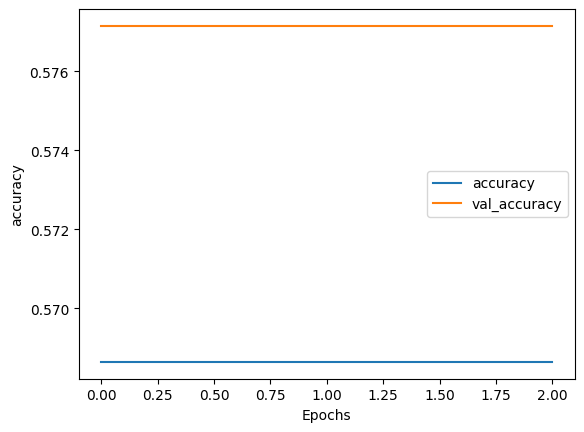

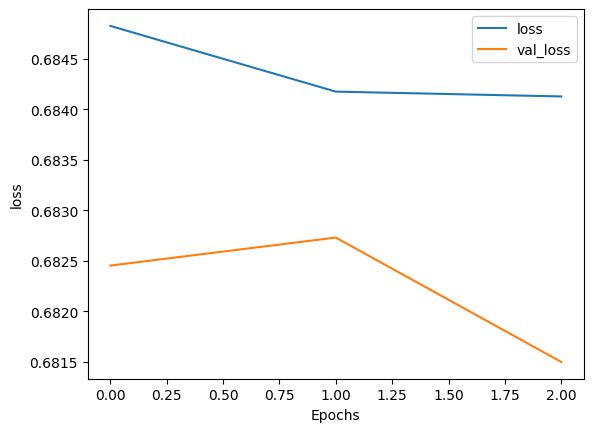

In [82]:
  
plot_graphs(LTSM_history, "accuracy")
plot_graphs(LTSM_history, "loss")

## RNN

In [84]:
RNN_model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.SimpleRNN(units=32,
                   activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
]
)


RNN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [85]:
RNN_history = RNN_model.fit(training_sequences, y_train, epochs = 50, validation_data = (val_sequences, y_val), callbacks = early_stopping, verbose = 2)

Epoch 1/50
191/191 - 13s - 66ms/step - accuracy: 0.5650 - loss: 0.6855 - val_accuracy: 0.5772 - val_loss: 0.6812
Epoch 2/50
191/191 - 11s - 56ms/step - accuracy: 0.5619 - loss: 0.6843 - val_accuracy: 0.5772 - val_loss: 0.6855
Epoch 3/50
191/191 - 10s - 55ms/step - accuracy: 0.5624 - loss: 0.6848 - val_accuracy: 0.5772 - val_loss: 0.6805


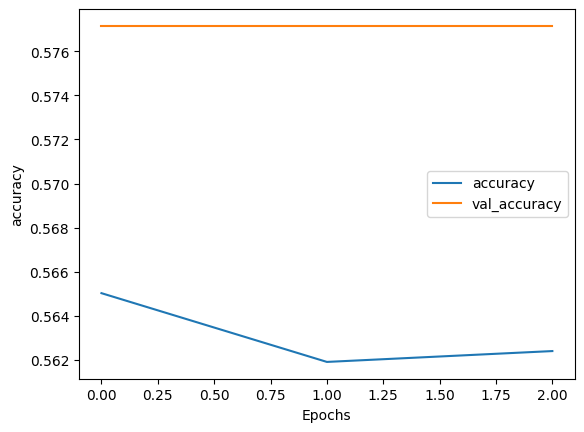

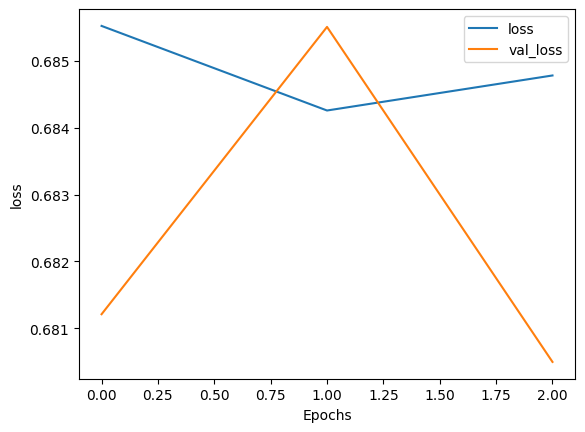

In [86]:
plot_graphs(RNN_history, "accuracy")
plot_graphs(RNN_history, "loss")

Niether the LSTM or the simple RNN model appeared to do very well. I think by making more complex LSTM / RNN models we could improve, but our first NN model did pretty well, so we will stick with that for now. In the future, I would like to spend more time creating better LSTM / RNN models, as well as expirement with some transformer models, like BERT.